In [663]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb
import scipy
import time
from imblearn.over_sampling import SMOTE
from bayes_opt import BayesianOptimization 
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import lightgbm as lgb

In [664]:
import tensorflow as tf

In [665]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [666]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')

In [667]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [668]:
dataset_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

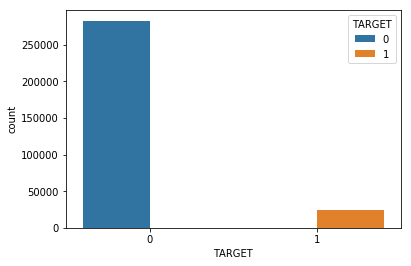

In [669]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train)

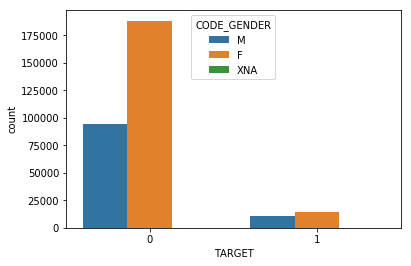

In [670]:
sb.countplot(x='TARGET',hue='CODE_GENDER',data=dataset_train)

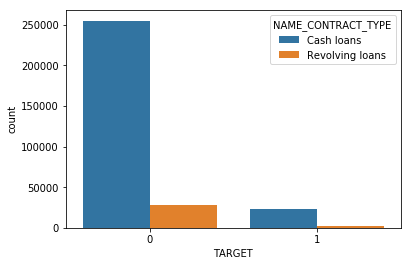

In [671]:
sb.countplot(x='TARGET',hue='NAME_CONTRACT_TYPE',data=dataset_train)

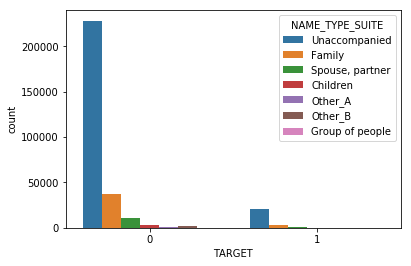

In [672]:
sb.countplot(x='TARGET',hue='NAME_TYPE_SUITE',data=dataset_train)

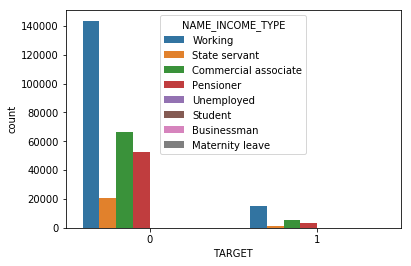

In [673]:
sb.countplot(x='TARGET',hue='NAME_INCOME_TYPE',data=dataset_train)

In [674]:
(dataset_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

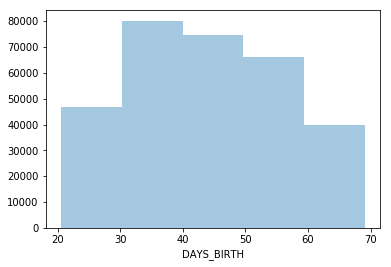

In [675]:
sb.distplot(dataset_train['DAYS_BIRTH']/-365,bins=5,kde=False)

In [676]:
len(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0])

55374

In [677]:
(dataset_train[dataset_train['DAYS_EMPLOYED'] > 0]['TARGET'] == 1).value_counts()

False    52384
True      2990
Name: TARGET, dtype: int64

In [678]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    307511.000000
mean        185.547239
std         382.037676
min           0.000000
25%           2.556164
50%           6.079452
75%          15.635616
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

In [679]:
max(dataset_train['DAYS_EMPLOYED'])

365243

In [680]:
len(dataset_train['DAYS_EMPLOYED'] == 365243)

307511

In [681]:
dataset_train['EMP_AN'] = dataset_train['DAYS_EMPLOYED'] == 365243

In [682]:
dataset_train['DAYS_EMPLOYED'] = dataset_train['DAYS_EMPLOYED'].replace({365243: np.nan})

In [683]:
(abs(dataset_train['DAYS_EMPLOYED']/365)).describe()

count    252137.000000
mean          6.531971
std           6.406466
min           0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [684]:
(abs(dataset_train['DAYS_REGISTRATION']/365)).describe()

count    307511.000000
mean         13.660604
std           9.651743
min           0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

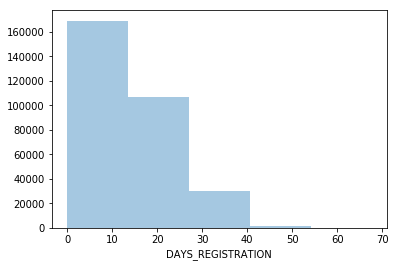

In [685]:
sb.distplot(dataset_train['DAYS_REGISTRATION']/-365,bins=5,kde=False)

In [686]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

80

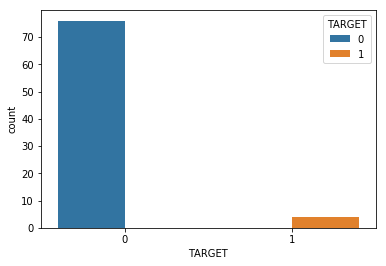

In [687]:
sb.countplot(x='TARGET',hue='TARGET',data=dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50])

In [688]:
dataset_train = dataset_train.drop(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50].index,axis=0)

In [689]:
len(dataset_train[dataset_train['DAYS_REGISTRATION']/-365 > 50]['DAYS_BIRTH']/-365 > 50)

0

In [690]:
dataset_train.shape

(307431, 123)

In [692]:
corr = dataset_train.corr(method='pearson')

In [693]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

CNT_CHILDREN - CNT_FAM_MEMBERS
0.8791849055884082
AMT_CREDIT - AMT_ANNUITY
0.7701355325112837
REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.9508244177203856
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.8606542659268078
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8255558750839367
APARTMENTS_AVG - ELEVATORS_AVG
0.8369526900299763
BASEMENTAREA_AVG - BASEMENTAREA_MODE
0.973496185301789
YEARS_BEGINEXPLUATATION_AVG - YEARS_BEGINEXPLUATATION_MODE
0.97189305389083
YEARS_BUILD_AVG - YEARS_BUILD_MODE
0.9894360514168624
COMMONAREA_AVG - COMMONAREA_MODE
0.9771461116759385
ENTRANCES_AVG - ENTRANCES_MODE
0.9777417653401914
FLOORSMAX_AVG - FLOORSMIN_AVG
0.7424268126795673
LANDAREA_AVG - LANDAREA_MODE
0.9736925929909296
LIVINGAPARTMENTS_AVG - LIVINGAREA_AVG
0.8807913124080583
NONLIVINGAPARTMENTS_AVG - NONLIVINGAPARTMENTS_MODE
0.9693697425066614
NONLIVINGAREA_AVG - NONLIVINGAREA_MODE
0.9660854607189583
APARTMENTS_MODE - ELEVATORS_MODE
0.8262109330460732
FLOORSMAX_MODE - FLOO

In [694]:
#Columnd to remove die to high correlation (Only measured colinearity among pairs of parameters still have to deal
#with multi-colinearity)
columns_to_remove = ['CNT_CHILDREN','REGION_RATING_CLIENT_W_CITY','REG_REGION_NOT_WORK_REGION',
                    'LIVE_CITY_NOT_WORK_CITY','ELEVATORS_AVG','BASEMENTAREA_MODE','YEARS_BEGINEXPLUATATION_MODE',
                    'YEARS_BUILD_MODE','COMMONAREA_MODE','ENTRANCES_MODE','FLOORSMIN_AVG','LANDAREA_MODE',
                    'LIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MODE','ELEVATORS_MODE','FLOORSMIN_MODE',
                    'LIVINGAREA_MODE','ELEVATORS_MEDI','FLOORSMIN_MEDI','LIVINGAREA_MEDI','OBS_60_CNT_SOCIAL_CIRCLE',
                    'DEF_60_CNT_SOCIAL_CIRCLE']

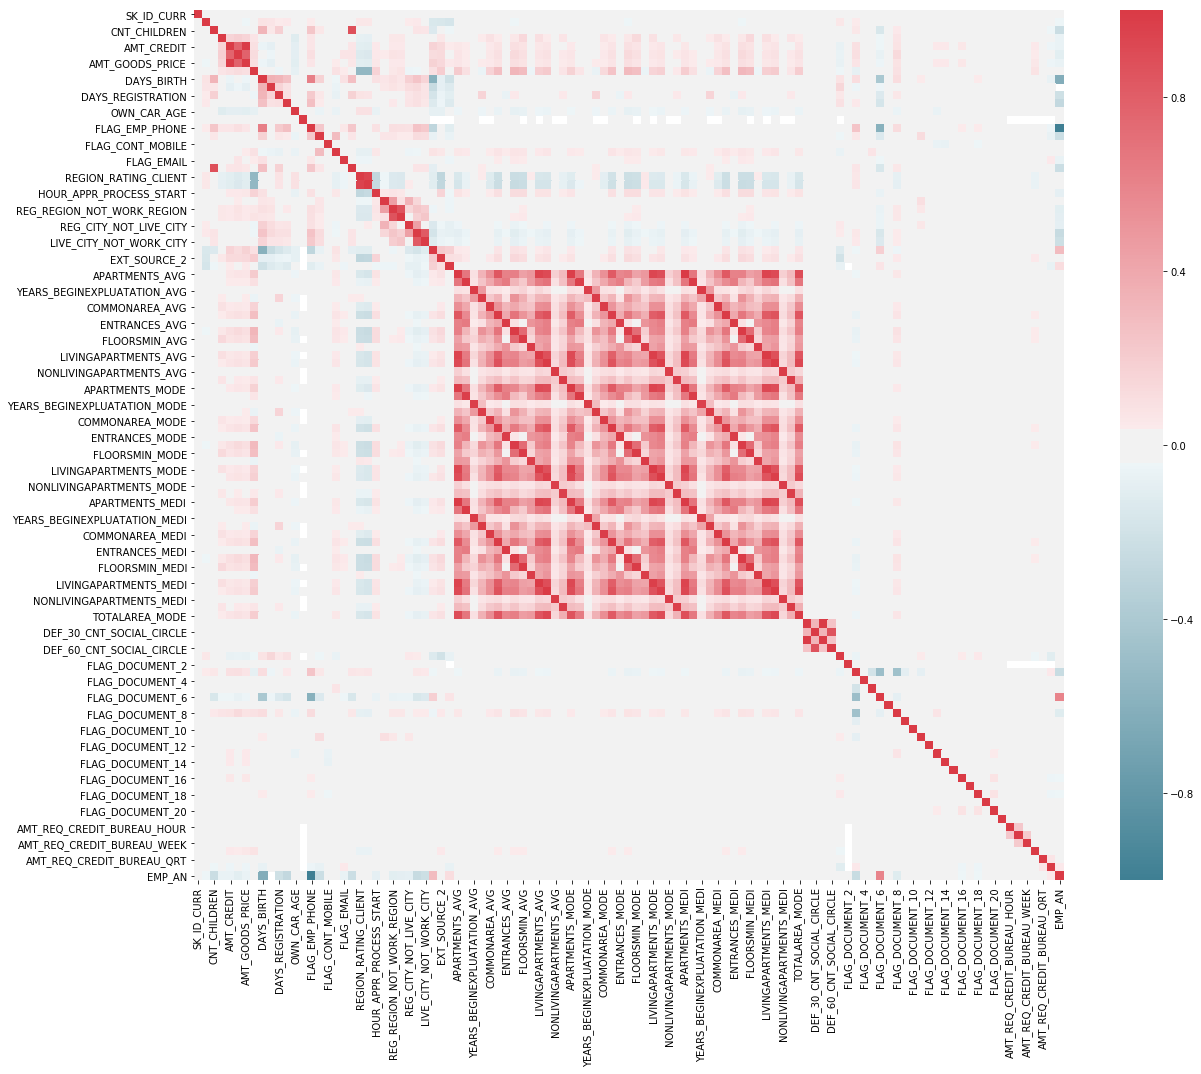

In [695]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [696]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

In [697]:
dataset_train.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [698]:
columns_to_label_encode = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']
starttime = time.time()
for column in columns_to_label_encode:
    le = LabelEncoder()
    dataset_train[column] = le.fit_transform(dataset_train[column].astype(str))
endtime = time.time()
print("Time Elapsed:- ")
print(endtime - starttime)

Time Elapsed:- 
1.0233049392700195


In [699]:
columns_to_one_hot_encode = ['CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                             'OCCUPATION_TYPE','ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START',
                            'FONDKAPREMONT_MODE','WALLSMATERIAL_MODE','HOUSETYPE_MODE']
starttime = time.time()
for column in columns_to_one_hot_encode:
    le = LabelEncoder()
    oe = OneHotEncoder()
    label_encoded = le.fit_transform(dataset_train[column].astype(str))
    label_encoded = label_encoded.reshape(-1,1)
    one_hot_encoded = oe.fit_transform(label_encoded).toarray()
    df = pd.DataFrame(one_hot_encoded,columns=[column + str(i) for i in range(0,one_hot_encoded.shape[1])])
    df = df.drop([column + "0"],axis=1)
    dataset_train = pd.concat([dataset_train,df],axis=1)
    print(column + " - " + str(dataset_train.shape[0]) + " " + str(dataset_train.shape[1]))
dataset_train = dataset_train.drop(columns_to_one_hot_encode,axis=1)
dataset_train.shape

CODE_GENDER - 307511 103
NAME_TYPE_SUITE - 307511 110
NAME_INCOME_TYPE - 307511 118
NAME_EDUCATION_TYPE - 307511 123
NAME_FAMILY_STATUS - 307511 129
NAME_HOUSING_TYPE - 307511 135
OCCUPATION_TYPE - 307511 153
ORGANIZATION_TYPE - 307511 211
WEEKDAY_APPR_PROCESS_START - 307511 218
FONDKAPREMONT_MODE - 307511 222
WALLSMATERIAL_MODE - 307511 229
HOUSETYPE_MODE - 307511 232


(307511, 220)

In [700]:
dataset_train['DIR'] = dataset_train['AMT_CREDIT']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['AIR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_INCOME_TOTAL']
dataset_train['ACR'] = dataset_train['AMT_ANNUITY']/dataset_train['AMT_CREDIT']
dataset_train['DAR'] = dataset_train['DAYS_EMPLOYED']/dataset_train['DAYS_BIRTH']

In [701]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(35000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [702]:
from sklearn.preprocessing import StandardScaler, Imputer
imputer = Imputer(strategy='median')
scalet = StandardScaler()
dataset_train_tr = imputer.fit_transform(dataset_train.drop(['SK_ID_CURR','TARGET'],axis=1))
dataset_train_tr = scaler.fit_transform(dataset_train_tr)

In [703]:
X = dataset_train_tr
y = dataset_train['TARGET']

In [704]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [705]:
X_test = pd.DataFrame(X_test,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']))

In [706]:
#Using SMOTE(Synthetic Minority Oversampling Technique) to handle imbalanced dataset
smote = SMOTE(random_state=232)
os_data_X,os_data_y = smote.fit_sample(X_train,y_train)
X_train = pd.DataFrame(data=os_data_X,columns=dataset_train.columns.drop(['SK_ID_CURR','TARGET']) )
y_train = pd.DataFrame(data=os_data_y,columns=["TARGET"])

In [707]:
X_train.shape

(55968, 222)

In [708]:
y_train.shape

(55968, 1)

In [709]:
def generate_classifier_report(classifier,predictions,predictions_prob,name):
    print(classification_report(y_test,predictions))
    logit_roc_score = roc_auc_score(y_test,predictions)
    fpr, tpr, thresholds = roc_curve(y_test,predictions_prob)
    plt.figure()
    plt.plot(fpr,tpr,label=name + " AUC score:- " + str(logit_roc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False Positive Rate (FP / (FP + TN))')
    plt.ylabel('True Positive Rate (TP / (TP + FN))')
    plt.title('Receiver Operating Characteristics Curve')
    plt.legend(loc="lower right")
    plt.savefig(name + "_roc_curve")
    plt.show()

In [710]:
X.shape

(55000, 222)

In [711]:
y.shape

(55000,)

In [712]:
clf = LogisticRegression(C=0.4,max_iter = 1000)
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [713]:
prediction = clf.predict(X_test)

In [714]:
accuracy_score(y_test,prediction)

0.6889090909090909

In [715]:
confusion_matrix(y_test,prediction)

array([[4868, 2148],
       [1274, 2710]])

             precision    recall  f1-score   support

        0.0       0.79      0.69      0.74      7016
        1.0       0.56      0.68      0.61      3984

avg / total       0.71      0.69      0.69     11000



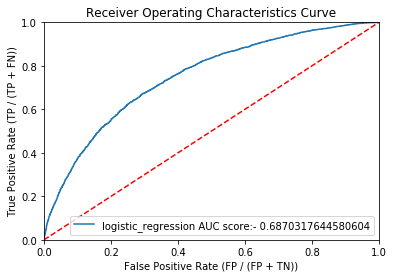

In [716]:
generate_classifier_report(clf,prediction,clf.predict_proba(X_test)[:,1],name="logistic_regression")

In [718]:
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [719]:
prediction = classifier.predict(X_test)

In [720]:
confusion_matrix(y_test,prediction)

array([[5770, 1246],
       [2434, 1550]])

In [721]:
accuracy_score(y_test,prediction)

0.6654545454545454

             precision    recall  f1-score   support

        0.0       0.70      0.82      0.76      7016
        1.0       0.55      0.39      0.46      3984

avg / total       0.65      0.67      0.65     11000



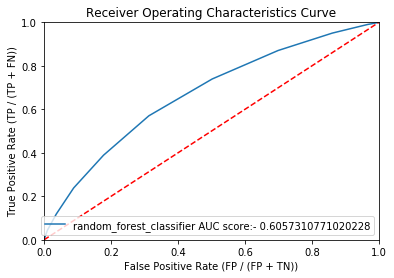

In [722]:
generate_classifier_report(classifier,prediction,classifier.predict_proba(X_test)[:,1],"random_forest_classifier")

In [723]:
boosting = XGBClassifier(alpha=1,eval_metric='logloss')
boosting.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='logloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [724]:
X_train.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'WALLSMATERIAL_MODE5', 'WALLSMATERIAL_MODE6', 'WALLSMATERIAL_MODE7',
       'HOUSETYPE_MODE1', 'HOUSETYPE_MODE2', 'HOUSETYPE_MODE3', 'DIR', 'AIR',
       'ACR', 'DAR'],
      dtype='object', length=222)

In [725]:
pred = boosting.predict(X_test)
accuracy_score(y_test,pred)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7095454545454546

In [727]:
confusion_matrix(y_test,pred)

array([[5694, 1322],
       [1873, 2111]])

             precision    recall  f1-score   support

        0.0       0.75      0.81      0.78      7016
        1.0       0.61      0.53      0.57      3984

avg / total       0.70      0.71      0.70     11000



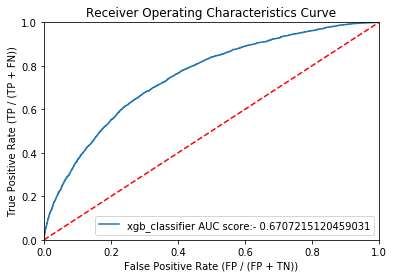

In [728]:
generate_classifier_report(boosting,pred,boosting.predict_proba(X_test)[:,1],'xgb_classifier')

In [729]:
clf = lgb.LGBMClassifier(boosting_type='gbdt')
clf.fit(X_train,y_train)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [730]:
pref = clf.predict(X_test)
accuracy_score(y_test,pred)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7095454545454546

In [731]:
confusion_matrix(y_test,pred).ravel()

array([5694, 1322, 1873, 2111])

             precision    recall  f1-score   support

        0.0       0.75      0.81      0.78      7016
        1.0       0.61      0.53      0.57      3984

avg / total       0.70      0.71      0.70     11000



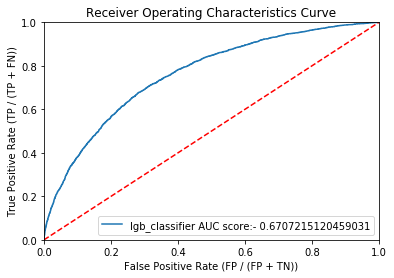

In [732]:
generate_classifier_report(clf,pred,clf.predict_proba(X_test)[:,1],'lgb_classifier')

In [535]:
X = tf.placeholder(shape=[None,222],dtype=tf.float32)
y = tf.placeholder(shape=[None,1],dtype=tf.int64)

In [540]:
weights = {
    'W1': tf.Variable(tf.truncated_normal(shape=[222,140])),
    'W2': tf.Variable(tf.truncated_normal(shape=[140,70])),
    'W3': tf.Variable(tf.truncated_normal(shape=[70,27])),
    'W4': tf.Variable(tf.truncated_normal(shape=[27,2]))
}
biases = {
    'b1': tf.Variable(tf.truncated_normal(shape=[140])),
    'b2': tf.Variable(tf.truncated_normal(shape=[70])),
    'b3': tf.Variable(tf.truncated_normal(shape=[27])),
    'b4': tf.Variable(tf.truncated_normal(shape=[2]))
}

In [541]:
def get_model(X,weights,biases):
    op1 = tf.add(tf.matmul(X,weights['W1']),biases['b1'])
    relu_op1 = tf.nn.relu(op1) 
    op2 = tf.add(tf.matmul(relu_op1,weights['W2']),biases['b2'])
    relu_op2 = tf.nn.relu(op2)
    op3 = tf.add(tf.matmul(relu_op2,weights['W3']),biases['b3'])
    relu_op3 = tf.nn.relu(op3)
    op4 = tf.add(tf.matmul(relu_op3,weights['W4']),biases['b4'])
    return op4

In [ ]:
pred = get_model(X,weights,biases)
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=pred))
train_step = optimizer.minimize(loss)

In [ ]:
#Improve accuracy here
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(0,10):
        cost = 0
        total_batch = X_train.shape[0]/100
        X_batches = np.array_split(X_train,total_batch)
        y_batches = np.array_split(y_train,total_batch)
        for j in range(0,int(total_batch)):
            _,c = sess.run([train_step,loss],feed_dict={
                X: X_batches[j],
                y: y_batches[j]
            })
            cost = cost + c/total_batch
        print("Epoch:- " + str(i) + " Cost:- " + str(cost))
    correct_prediction = tf.equal(tf.argmax(pred,1),y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,"float"))
    print("Accuracy:- " + str(accuracy.eval({X: X_test,y: y_test})))

In [450]:
clf = SVC(gamma=0.001, C=1.0, kernel='poly')
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [451]:
pred = clf.predict(X_test)
accuracy_score(y_test,pred)

0.51475

In [453]:
confusion_matrix(y_test,pred).ravel()

array([ 210, 3751,  131, 3908])